In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")
df.head()

Mounted at /content/drive


,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


#KMeans（Find optimal k by calculating minimum SSE）

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


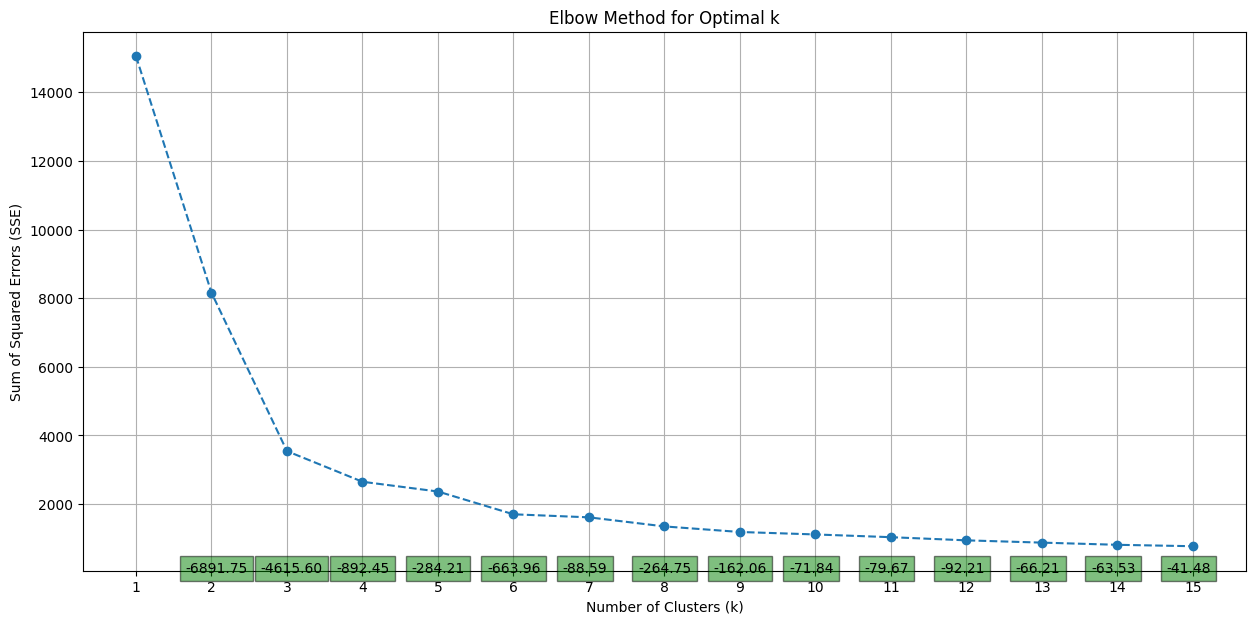

Optimal k is 14


In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. 載入資料
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")

# 2. 擷取特徵
features = df.drop(columns=["filename", "label"])

# 3. Standardize the data for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. 降維到 2 個主要特徵
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# 5. 使用 Elbow Method 計算不同 n_clusters 的 SSE
sse = []  # 存放每個 n_clusters 對應的 SSE
cluster_range = range(1, 16)  # 測試 1 到 15 個聚類
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  # 設定隨機種子以確保重現性
    kmeans.fit(reduced_features)
    sse.append(kmeans.inertia_)  # KMeans 的 inertia_ 屬性即為 SSE


minimum_sse = 1000000
optimal_k = -1
# 6. 繪製 Elbow Method 圖形
plt.figure(figsize=(15, 7))
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(cluster_range)
for k in range(1, 15):
    plt.text(k+0.65, 1, f"{sse[k]-sse[k-1]:.2f}", bbox=dict(facecolor='green', alpha=0.5))
    if abs(sse[k]-sse[k-1]) < 0.1:
      optimal_k = k
      break
    elif minimum_sse > abs(sse[k]-sse[k-1]):
      minimum_sse = abs(sse[k]-sse[k-1])
      optimal_k = k
plt.grid()
plt.show()

print(f"Optimal k is {optimal_k}")

#KMeans（Show result）

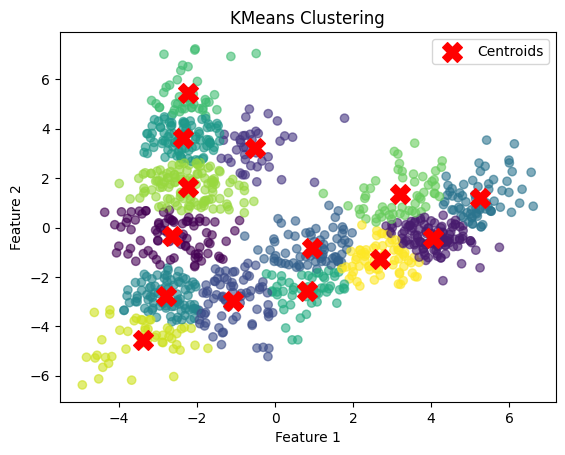

In [ ]:
# 7. 設定 KMeans 模型
kmeans = KMeans(n_clusters=optimal_k)


# 8. 擬合模型
kmeans.fit(reduced_features)


# 9. 獲取結果
df['cluster'] = kmeans.labels_


# 10. Visualize the first two dimensions of the data and clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#AgglomerativeClustering（Find optimal n_clusters by calculating minimum SSE）

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


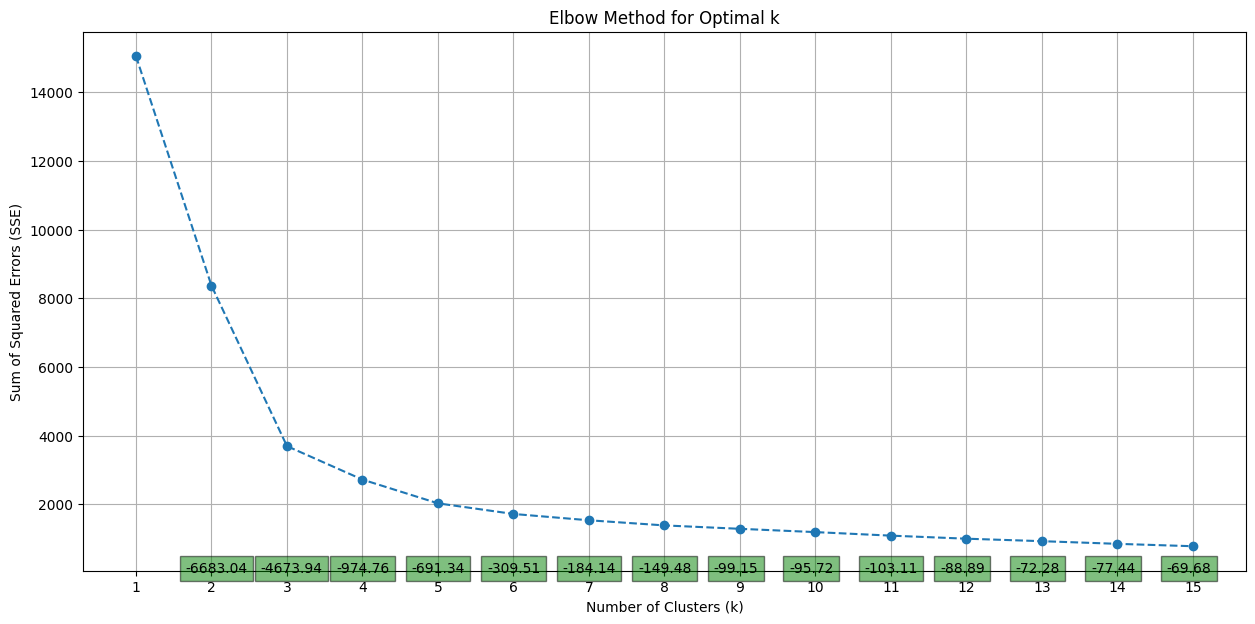

Optimal k is 14


In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np

# 1. 載入資料
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")

# 2. 擷取特徵
features = df.drop(columns=["filename", "label"])

# 3. Standardize the data for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# 4. 降維到 2 個主要特徵
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)




sse = []
cluster_range = range(1, 16)
for n in cluster_range:  # 測試簇數從 1 到 15
    clustering = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = clustering.fit_predict(reduced_features)

    # 計算 SSE
    cluster_centers = np.array([reduced_features[labels == i].mean(axis=0) for i in range(n)])
    distances = np.min(cdist(reduced_features, cluster_centers, 'euclidean'), axis=1)
    sse.append(np.sum(distances**2))


minimum_sse = 1000000
optimal_k = -1
# 6. 繪製 Elbow Method 圖形
plt.figure(figsize=(15, 7))
plt.plot(cluster_range, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(cluster_range)
for k in range(1, 15):
    plt.text(k+0.65, 1, f"{sse[k]-sse[k-1]:.2f}", bbox=dict(facecolor='green', alpha=0.5))
    if abs(sse[k]-sse[k-1]) < 0.1:
      optimal_k = k
      break
    elif minimum_sse > abs(sse[k]-sse[k-1]):
      minimum_sse = abs(sse[k]-sse[k-1])
      optimal_k = k
plt.grid()
plt.show()

print(f"Optimal k is {optimal_k}")

#AgglomerativeClustering（Show result）

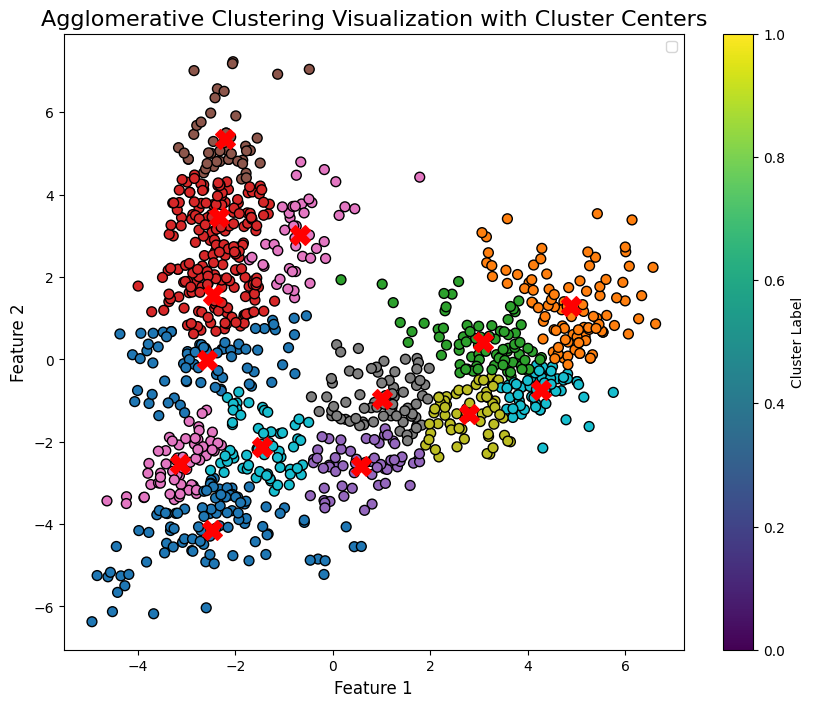

In [ ]:
# 5. 使用 AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')


# 6. 擬合模型
clustering.fit(reduced_features)

# 7. 可視化結果
plt.figure(figsize=(10, 8))

# 畫出每個數據點
plt.scatter(
    reduced_features[:, 0],  # PCA 第一主成分
    reduced_features[:, 1],  # PCA 第二主成分
    c=clustering.labels_,    # 使用群集標籤著色
    cmap='tab10',            # 使用 10 種顏色的調色盤
    s=50,                    # 點的大小
    edgecolor='k'            # 點的邊框顏色
)

# 計算並畫出每個簇的中心點
unique_labels = np.unique(clustering.labels_)
for label in unique_labels:
    cluster_points = reduced_features[clustering.labels_ == label]  # 選擇該簇的所有點
    centroid = cluster_points.mean(axis=0)  # 計算質心
    plt.scatter(
        centroid[0], centroid[1],
        c='red',    # 用紅色標註中心
        marker='X', # 使用 'X' 標記
        s=200,      # 標記大小
    )

# 圖片標題與軸標籤
plt.title("Agglomerative Clustering Visualization with Cluster Centers", fontsize=16)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend()  # 顯示圖例
plt.colorbar(label="Cluster Label")  # 添加顏色對應的標籤
plt.show()

#DBSCAN（Determining EPS and Minpts）

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


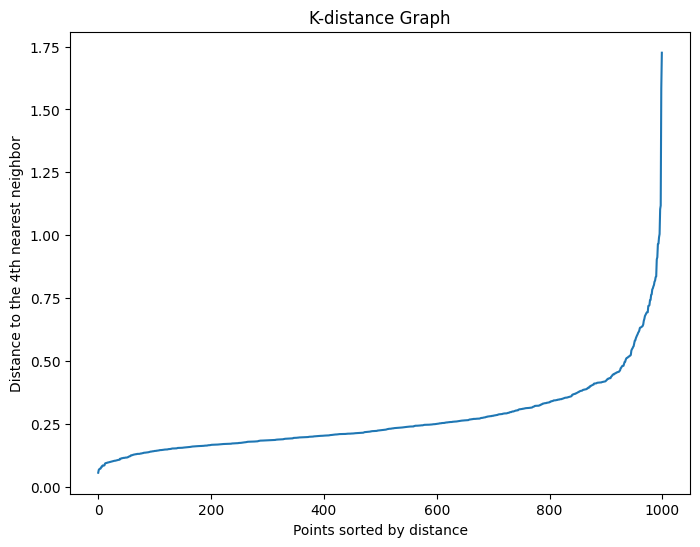

In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt


# 1. 載入資料
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")

# 2. 擷取特徵
features = df.drop(columns=["filename", "label"])

# 3. Standardize the data for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. 降維到 2 個主要特徵
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# 計算每個點的 k 邊界距離（min_samples 設為 4）
min_samples = 4
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(reduced_features)
distances, indices = neighbors_fit.kneighbors(reduced_features)


# 計算每個點的距離，取倒數並排序
distances = sorted(distances[:, -1])


# 繪製 K 邊界距離圖
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to the 4th nearest neighbor")
plt.show()


#DBSCAN（Show result）

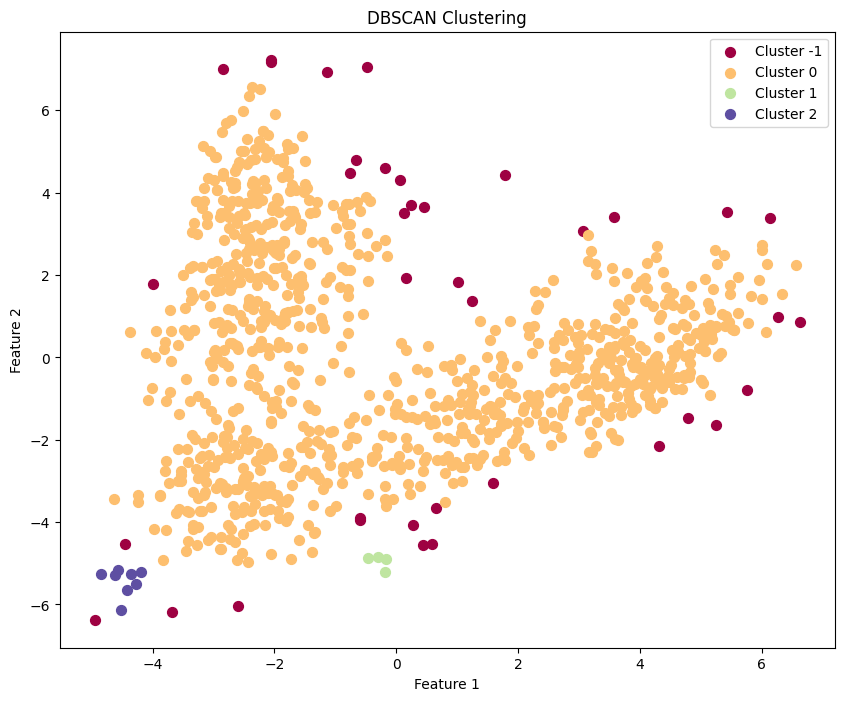

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# 應用 DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=min_samples)
labels = dbscan.fit_predict(reduced_features)

# 將結果加入原始資料
df['cluster'] = labels



# 視覺化
plt.figure(figsize=(10, 8))
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = labels == label
    plt.scatter(reduced_features[mask, 0], reduced_features[mask, 1], s=50, c=[color], label=f'Cluster {label}')

plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

#normalized_mutual_info_score

In [4]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import normalized_mutual_info_score

# 1. 載入資料
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")

# 2. 擷取特徵
features = df.drop(columns=["filename", "label"])
true_labels = df.iloc[:, -1]

# 3. Standardize the data for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. 降維到 2 個主要特徵
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)


# 5. 設定 KMeans 模型
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k)


# 6. 擬合模型
predicted_labels = kmeans.fit_predict(reduced_features)


# 7. 計算正規化互信息分數
nmi_Kmeans = normalized_mutual_info_score(labels_true = true_labels, labels_pred = predicted_labels, average_method='arithmetic')


# 8. 使用 AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')

# 9. 擬合模型
predicted_labels = clustering.fit_predict(reduced_features)

# 10. 計算正規化互信息分數
nmi_AgglomerativeClustering = normalized_mutual_info_score(true_labels, predicted_labels, average_method='arithmetic')


print(f"KMeans NMI: {nmi_Kmeans:.3f}, AgglomerativeClustering NMI: {nmi_AgglomerativeClustering:.3f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
KMeans NMI: 0.291, AgglomerativeClustering NMI: 0.286


#silhouette_score

In [5]:
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 1. 載入資料
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/data mining HW8/data.csv")

# 2. 擷取特徵
features = df.drop(columns=["filename", "label"])

# 3. Standardize the data for better clustering performance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 4. 降維到 2 個主要特徵
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)


# 5. 設定 KMeans 模型
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k)


# 6. 擬合模型
predicted_labels = kmeans.fit_predict(reduced_features)


# 7. 計算正規化互信息分數
silhouette_Kmeans  = silhouette_score(X = reduced_features, labels = predicted_labels, metric='euclidean')


# 8. 應用 DBSCAN
min_samples = 4
dbscan = DBSCAN(eps=0.5, min_samples=min_samples)

# 9. 擬合模型
predicted_labels = dbscan.fit_predict(reduced_features)

# 10. 計算正規化互信息分數
silhouette_DBSCAN = silhouette_score(X = reduced_features, labels = predicted_labels, metric='euclidean')

print(f"KMeans Silhouette: {silhouette_Kmeans:.3f}, DBSCAN Silhouette: {silhouette_DBSCAN:.3f}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
KMeans Silhouette: 0.345, DBSCAN Silhouette: -0.002
